In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

from shapely.geometry import Point


#Shape file need for reference in project
#https://data.gov.uk/dataset/65ee9eeb-5313-4b26-bc7e-e4aac1b27358/nuts-level-2-january-2018-full-clipped-boundaries-in-the-united-kingdom

In [3]:
df = pd.read_csv("Data/Data_V1.4.csv")
Postcode_Loopuk_df = pd.read_csv("Data/ukpostcodes.csv")
df_population_size = pd.read_csv("Data/postcodes/Population.csv", index_col ="Region_Code")
print(len(df))

133460


In [4]:
Postcode_Loopuk_df.head(5)

,id,postcode,latitude,longitude
0,1,AB10 1XG,57.144165,-2.114848
1,2,AB10 6RN,57.137880,-2.121487
2,3,AB10 7JB,57.124274,-2.127190
3,4,AB11 5QN,57.142701,-2.093295
4,5,AB11 6UL,57.137547,-2.112233


In [5]:
UK_Shape = gpd.read_file('NUTS_Level_2_January_2018_Full_Clipped_Boundaries_in_the_United_Kingdom.shp')

In [6]:
UK_Shape.head(5)

,objectid,nuts218cd,nuts218nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.77440,54.685020,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...
1,2,UKC2,Northumberland and Tyne and Wear,398898,602530,-2.01892,55.316841,5.566181e+09,751311.485119,(POLYGON ((-2.024151451980134 55.7711741685706...
2,3,UKD1,Cumbria,341868,527389,-2.90218,54.638260,6.822195e+09,987066.701024,(POLYGON ((-2.675590620680368 55.1733220183547...
3,4,UKD3,Greater Manchester,377940,401102,-2.33407,53.506149,1.275981e+09,248705.119145,"POLYGON ((-2.13224594777332 53.68404821070088,..."
4,5,UKD4,Lancashire,363669,441026,-2.55392,53.864182,3.076413e+09,795004.920936,(POLYGON ((-2.459141139619598 54.2367471854683...


We want to create the postcode and then join this to the Post Code look up data set to get the latitude and longitude

In [7]:
df["postcode"] = df["PO_OUT"] + " " + df["PO_IN"]
Postcode_Loopuk_df.head(5)

df_final = df.merge(Postcode_Loopuk_df, on=["postcode","postcode"] , how="inner").copy()
df_final = df_final.loc[df_final["latitude"] < 70]

In [8]:
df_final.head(5)

,URN,LAST_ASK,DV,INCOME,PAY_DATE,TIME_TILL_PAY,DATE_CR_DB,AGE_DESC,MOSAIC_GROUP,MOSAIC_GROUP_DESC,...,TOTAL_NUM_MONTH_PAID,DM_PREVIOUS_12_MONTHS,NUM_TRANS_LST_24,DONATED_LST_24,PO_OUT,PO_IN,postcode,id,latitude,longitude
0,1,16/3/2017 00:00:00,0,NaN,NaN,NaN,1/1/1985 00:00:00,Age 66-70,5.0,Senior Security,...,0,3,0,0.00,DD6,9EX,DD6 9EX,1342255,56.448080,-2.876381
1,2,16/3/2017 00:00:00,0,NaN,NaN,NaN,1/5/1999 00:00:00,Age 46-50,7.0,Domestic Success,...,0,-1,0,0.00,RG41,2RA,RG41 2RA,486258,51.408066,-0.845038
2,3,6/10/2018 00:00:00,0,NaN,NaN,NaN,1/1/1985 00:00:00,Age 46-50,1.0,City Prosperity,...,455,11,48,648.00,AB11,7UR,AB11 7UR,1694363,57.136275,-2.108677
3,27892,6/10/2018 00:00:00,0,NaN,NaN,NaN,1/1/1985 00:00:00,Age 66-70,1.0,City Prosperity,...,403,-1,24,344.16,AB11,7UR,AB11 7UR,1694363,57.136275,-2.108677
4,47459,6/10/2018 00:00:00,0,NaN,NaN,NaN,1/2/1987 00:00:00,Age 46-50,1.0,City Prosperity,...,595,6,48,464.16,AB11,7UR,AB11 7UR,1694363,57.136275,-2.108677


### We need to turn those coordinates into data Points and then convert to a Geopandas dataframe. This Geo frame will then tell us which NUTS region each supporter lives in.

In [9]:
#Loops through current data frame and converts each long and Lat into points
geometry = [Point(xy) for xy in zip(df_final.longitude, df_final.latitude)]

df_final = df_final.drop(['latitude', 'longitude', 'id'], axis=1)
crs = {'init': 'epsg:4326'}

gdf_supporters = gpd.GeoDataFrame(df_final, crs=crs, geometry=geometry)

In [10]:
#Joins the dataset so we now know how many supporters are in each region
Join_Data = gpd.sjoin(UK_Shape, gdf_supporters, how="inner", op='intersects')

In [11]:
Join_Data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 132398 entries, 0 to 40
Data columns (total 44 columns):
objectid                 132398 non-null int64
nuts218cd                132398 non-null object
nuts218nm                132398 non-null object
bng_e                    132398 non-null int64
bng_n                    132398 non-null int64
long                     132398 non-null float64
lat                      132398 non-null float64
st_areasha               132398 non-null float64
st_lengths               132398 non-null float64
geometry                 132398 non-null object
index_right              132398 non-null int64
URN                      132398 non-null int64
LAST_ASK                 132398 non-null object
DV                       132398 non-null int64
INCOME                   12580 non-null float64
PAY_DATE                 12580 non-null object
TIME_TILL_PAY            12580 non-null float64
DATE_CR_DB               132389 non-null object
AGE_DESC                

In [12]:
Join_Data.head(10)

,objectid,nuts218cd,nuts218nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,...,NUM_ATTRITED_COG,NUM_DIFF_COG,TOTAL_YEARLY_CHARGE,TOTAL_NUM_MONTH_PAID,DM_PREVIOUS_12_MONTHS,NUM_TRANS_LST_24,DONATED_LST_24,PO_OUT,PO_IN,postcode
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,1,180.00,51,-1,24,360.0,TS12,2WF,TS12 2WF
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,1,360.00,705,6,48,720.0,TS12,2RL,TS12 2RL
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,1,180.00,338,6,24,360.0,TS12,1HT,TS12 1HT
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,1,240.00,484,6,48,480.0,TS11,8AN,TS11 8AN
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,1,0,0.00,0,-1,8,80.0,TS12,1JH,TS12 1JH
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,1,0,0.00,0,-1,0,0.0,TS12,1PB,TS12 1PB
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,1,450.12,550,-1,48,859.8,TS12,1HN,TS12 1HN
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,0,0.00,0,3,0,0.0,TS11,8JH,TS11 8JH
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,1,0,0.00,0,-1,2,10.0,TS12,1PD,TS12 1PD
0,1,UKC1,Tees Valley and Durham,414643,532242,-1.7744,54.68502,3.026249e+09,487438.014517,(POLYGON ((-1.737033618785907 54.9184631898649...,...,0,0,0.00,0,-1,0,0.0,TS12,1NU,TS12 1NU


In [13]:
print("Number of missing donros: ", len(df)-len(Join_Data))

Number of missing donros:  1062


We now have completed the join and can start to aggregate our data so it can be mapped to a NUTS 2 region

Due to issues around Polygons not being hashable I am grouping by NUTS code and then rejoining the aggregated data back onto the orginal data source

In [14]:
RR_Rate = (Join_Data.groupby(['nuts218cd'])['DV'].sum().sort_index()/Join_Data["nuts218cd"].value_counts().sort_index())*100

Mean_Gift = Join_Data.groupby(['nuts218cd'])['INCOME'].mean()

Avg_Value_lst_24 = Join_Data.groupby(['nuts218cd'])['DONATED_LST_24'].mean()

By setting the index to the NUTS2 region code we will be easily able to join on the series above. They will all have the same index

In [15]:
UK_Shape = UK_Shape.set_index("nuts218cd")

In [16]:
Map_Data = UK_Shape.join(Join_Data["nuts218cd"].value_counts().rename("Volume")).copy()

#Can overlay RR
Map_Data = Map_Data.join(RR_Rate.rename("RR"))

#Can overlay avg gift
Map_Data = Map_Data.join(Mean_Gift.rename("Mean Gift"))

#Overlay value donated in the last 24 months
Map_Data = Map_Data.join(Avg_Value_lst_24.rename("Value Last 24 Months"))

#Append population size of UK
Map_Data = Map_Data.join(df_population_size["2018"].rename("Population"))
Map_Data["Population"] = Map_Data["Population"].astype(int)

In [17]:
#Normalises to the population of that area.
Map_Data["Volume N"] = (Map_Data["Volume"]/Map_Data["Population"])*100

In [18]:
Map_Data[["nuts218nm", "Volume N"]].sort_values(by = "Volume N", ascending=False)

,nuts218nm,Volume N
nuts218cd,,
UKI3,Inner London - West,0.337423
UKI4,Inner London - East,0.285900
UKJ2,"Surrey, East and West Sussex",0.281772
UKK1,"Gloucestershire, Wiltshire and Bath/Bristol area",0.279244
UKJ1,"Berkshire, Buckinghamshire and Oxfordshire",0.272257
UKI6,Outer London - South,0.267942
UKI7,Outer London - West and North West,0.267519
UKM6,Highlands and Islands,0.264263
UKE2,North Yorkshire,0.261794


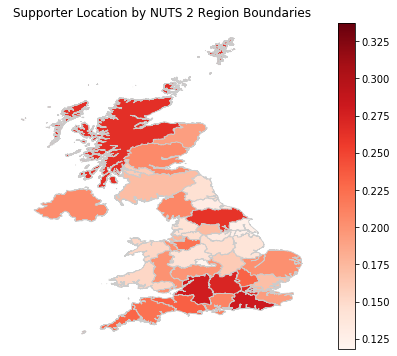

In [19]:
column_variable = "Volume N"

# set the range for the choropleth
vmin, vmax = Map_Data[column_variable].min(), Map_Data[column_variable].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# create map
Map_Data.plot(column=column_variable, cmap="Reds", linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis("off")
ax.set_title("Supporter Location by NUTS 2 Region Boundaries")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

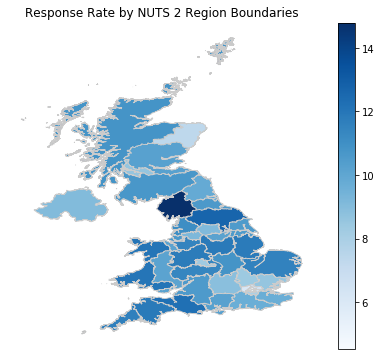

In [20]:
column_variable = "RR"

# set the range for the choropleth
vmin, vmax = Map_Data[column_variable].min(), Map_Data[column_variable].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# create map
Map_Data.plot(column=column_variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis("off")
ax.set_title("Response Rate by NUTS 2 Region Boundaries")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

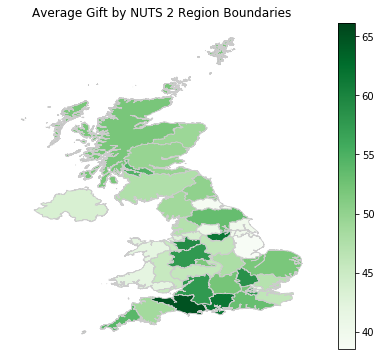

In [21]:
column_variable = "Mean Gift"

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# set the range for the choropleth
vmin, vmax = Map_Data[column_variable].min(), Map_Data[column_variable].max()

# create map
Map_Data.plot(column=column_variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis("off")
ax.set_title("Average Gift by NUTS 2 Region Boundaries")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [22]:
import folium
import urllib.request
import json 

In [35]:
# Uses a GeoJSON file foound on Github
with urllib.request.urlopen('https://opendata.arcgis.com/datasets/48b6b85bb7ea43699ee85f4ecd12fd36_4.geojson') as url:
    #Opens the GeoJSON
    uk_json = json.loads(url.read().decode()) 
    
#Creates the map
m = folium.Map(location=[54.584797 , -3.438721],
                        zoom_start=6,
                        min_zoon = 5)


folium.features.Choropleth(
geo_data=uk_json,
    data=Map_Data["RR"], #Volume N , RR
    #The key to link on in the GeoJSON
    key_on='feature.properties.nuts218cd',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Test Choropleth'
).add_to(m)
folium.LayerControl().add_to(m)

m

In [33]:
uk_json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'objectid': 1,
    'nuts218cd': 'UKC1',
    'nuts218nm': 'Tees Valley and Durham',
    'bng_e': 414643,
    'bng_n': 532242,
    'long': -1.7744,
    'lat': 54.68502045,
    'st_areashape': 3037019960.9501715,
    'st_lengthshape': 362943.9539241962},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-1.7362043585414308, 54.91858096474369],
      [-1.7249075921017958, 54.90880044280663],
      [-1.6986326871456925, 54.909053564326975],
      [-1.691689840987546, 54.90259760236341],
      [-1.674777784597975, 54.90956014342147],
      [-1.6755763964731818, 54.898096852878474],
      [-1.649318786051698, 54.892987310666335],
      [-1.650559547960282, 54.87932355234668],
      [-1.5941643487395494, 54.902018645987376],
      [-1.579909465654489, 54.87777014699237],
      [-1.5594107938228747, 54.88203711791987],
      [-1.5618096521810698, 54.87571675606061],
      [-1.5317817747652955, 54.8781883854